# Patents linked to Kent State University publications
_Created in June 2019 - Updated in August 2019_

Goal: we want to obtain info about all patents citing publications from a given university, in this case, [Kent State University (KSU)](https://grid.ac/institutes/grid.258518.3).

In [1]:
import time
#
import pandas as pd
from pandas.io.json import json_normalize
import plotly_express as px
#
from plotly.offline import init_notebook_mode # needed for exports 
init_notebook_mode(connected=True)
#
import dimcli
from dimcli.shortcuts import dslquery, dslqueryall, chunks_of, normalize_key
%dsl_login

DimCli v0.5.2.1 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


___
# 1. Data Extraction and Preparation

In [2]:
GRIDID = "grid.258518.3"
YEAR_START = "2009"

In [3]:
# Group publications by year (will be useful later to create a histogram)
df_all_pubs_per_year = dslquery(f"""search publications where research_orgs.id="{GRIDID}"return year limit 1000""").as_dataframe()

Returned Year: 92


In [4]:
# Get full list of reelvant publications linked to this organization
pubs_details = dslqueryall(f"""search publications where research_orgs.id="{GRIDID}" and year>="{YEAR_START}" return publications[basics+FOR]""")
df_pubs_details = pubs_details.as_dataframe()

1000 / 9156
2000 / 9156
3000 / 9156
4000 / 9156
5000 / 9156
6000 / 9156
7000 / 9156
8000 / 9156
9000 / 9156
9156 / 9156


In [5]:
# Create a new list of publications with simplifed FOR data
# Ensure that all pubs have a valid (empty, even) FOR value, also remove the FOR digit prefix to improve legibility
for x in pubs_details.publications:
    if not 'FOR' in x:
        x['FOR'] = ""
    else:
        x['FOR'] = [{'name' : x['name'][5:]} for x in x['FOR']] 
df_pubs_for = json_normalize(pubs_details.publications, record_path=['FOR'], meta=["id", "type", ["journal", "title"], "year"], errors='ignore', record_prefix='for_')

In [7]:
# Extract all patents linked to the publications dataset previously created
# Note: the patents query goes like this: `search patents where publication_ids in ["pub.1111511314", ...] return patents`
BATCHSIZE = 400

def run(ids_list):
    patents_out, n  = [], 0
    for chunk in chunks_of(ids_list, BATCHSIZE): # chunks of 200 args
        n += 1
        temp = ','.join(['"{}"'.format(i) for i in chunk])
        data = dslquery(f"""search patents where publication_ids in [{temp}] return patents[basics+publication_ids+FOR] limit 1000""")
        patents_out += data.patents
        print("[log] ", n*BATCHSIZE, " pubs > patents: ", len(data.patents))
        time.sleep(1)
    return patents_out
        
patents_list = run(list(df_pubs_details['id']))

Returned Patents: 0
[log]  400  pubs > patents:  0
Returned Patents: 0
[log]  800  pubs > patents:  0
Returned Patents: 0
[log]  1200  pubs > patents:  0
Returned Patents: 0
[log]  1600  pubs > patents:  0
Returned Patents: 0
[log]  2000  pubs > patents:  0
Returned Patents: 0
[log]  2400  pubs > patents:  0
Returned Patents: 0
[log]  2800  pubs > patents:  0
Returned Patents: 0
[log]  3200  pubs > patents:  0
Returned Patents: 3 (total = 3)
[log]  3600  pubs > patents:  3
Returned Patents: 2 (total = 2)
[log]  4000  pubs > patents:  2
Returned Patents: 3 (total = 3)
[log]  4400  pubs > patents:  3
Returned Patents: 8 (total = 8)
[log]  4800  pubs > patents:  8
Returned Patents: 6 (total = 6)
[log]  5200  pubs > patents:  6
Returned Patents: 4 (total = 4)
[log]  5600  pubs > patents:  4
Returned Patents: 8 (total = 8)
[log]  6000  pubs > patents:  8
Returned Patents: 4 (total = 4)
[log]  6400  pubs > patents:  4
Returned Patents: 13 (total = 13)
[log]  6800  pubs > patents:  13
Returne

After going through all publications and extracting related patents, let's save the patents data so that we can use it later:

In [8]:
df_patent_details = pd.DataFrame().from_dict(patents_list)
# save to CSV
df_patent_details.to_csv("data/KSU_patents_by_id.csv")
# display top 3 rows
df_patent_details.head(3)

FOR  \
0  [{'id': '2471', 'name': '0306 Physical Chemist...   
1  [{'id': '2447', 'name': '0303 Macromolecular a...   
2  [{'id': '2447', 'name': '0303 Macromolecular a...   

                                      assignee_names  \
0  [Audi AG, SHOEMAKER KRISTA MARIE, DARLING ROBE...   
1                                 [Audi AG, AUDI AG]   
2  [Audi AG, Toyota Motor Corp, AUDI AG, TOYOTA M...   

                                           assignees filing_status  \
0  [{'id': 'grid.427377.2', 'acronym': 'UTC', 'na...   Application   
1  [{'id': 'grid.423767.3', 'name': 'Audi (German...         Grant   
2  [{'id': 'grid.423767.3', 'name': 'Audi (German...         Grant   

   granted_year                 id  \
0           NaN  US-20130330657-A1   
1        2018.0      US-9923223-B2   
2        2018.0      US-9923224-B2   

                                      inventor_names publication_date  \
0  [Krista Marie Shoemaker, Robert Mason Darling,...       2013-12-12   
1                    [Zhiwei Yang, Mallika Gummalla]       2018-03-20   
2   [Zhiwei Yang, Mallika Gummalla, Yoichi Hosokawa]       2018-03-20   

                                     publication_ids  times_cited  \
0                                   [pub.1055134419]            4   
1  [pub.1050216645, pub.1003485683, pub.102928896...            0   
2  [pub.1050216645, pub.1003485683, pub.102928896...            0   

                                               title  year  
0  UNITIZED ELECTRODE ASSEMBLY WITH HIGH EQUIVALE...  2011  
1  Electrolyte membrane, dispersion and method th...  2012  
2       Proton exchange material and method therefor  2012

In [9]:
# Normalise the assignees data in order to analyse it further later on 
normalize_key('assignees', patents_list)
# build a dataframe
df_patents_assignees = json_normalize(patents_list, record_path=['assignees'], meta=['id', 'year', 'title'], meta_prefix="grant_")
# save to CSV 
df_patents_assignees.to_csv("data/KSU_patents_by_assignees.csv")
df_patents_assignees.head()

acronym   country_name             id                                 name  \
0     UTC  United States  grid.427377.2  United Technologies (United States)   
1     NaN        Germany  grid.423767.3                       Audi (Germany)   
2     NaN        Germany  grid.423767.3                       Audi (Germany)   
3     NaN        Germany  grid.423767.3                       Audi (Germany)   
4     NaN          Japan  grid.462975.b     Toyota Motor Corporation (Japan)   

            grant_id  grant_year  \
0  US-20130330657-A1        2011   
1  US-20130330657-A1        2011   
2      US-9923223-B2        2012   
3      US-9923224-B2        2012   
4      US-9923224-B2        2012   

                                         grant_title  
0  UNITIZED ELECTRODE ASSEMBLY WITH HIGH EQUIVALE...  
1  UNITIZED ELECTRODE ASSEMBLY WITH HIGH EQUIVALE...  
2  Electrolyte membrane, dispersion and method th...  
3       Proton exchange material and method therefor  
4       Proton exchange material and method therefor

In [10]:
# Normalize FOR codes as above
for x in patents_list:
    if not 'FOR' in x:
        x['FOR'] = ""
    else:
        x['FOR'] = [{'name' : x['name'][5:]} for x in x['FOR']] 
df_patents_for = json_normalize(patents_list, record_path=['FOR'], meta=["id", "year", "title"], errors='ignore', record_prefix='for_')
# save to CSV 
df_patents_for.to_csv("data/KSU_patents_by_FOR.csv")
df_patents_for.head()

for_name                 id  year  \
0   Physical Chemistry (incl. Structural)  US-20130330657-A1  2011   
1  Macromolecular and Materials Chemistry      US-9923223-B2  2012   
2  Macromolecular and Materials Chemistry      US-9923224-B2  2012   
3                                Genetics      US-9701675-B2  2016   
4                  Biomedical Engineering   WO-2017218635-A2  2017   

                                               title  
0  UNITIZED ELECTRODE ASSEMBLY WITH HIGH EQUIVALE...  
1  Electrolyte membrane, dispersion and method th...  
2       Proton exchange material and method therefor  
3  Activation of TRPV4 ion channel by physical st...  
4  ACTIVATED RELEASE OF TARGET MATERIAL TRAPPED I...

Finally, let's create another publications index, including only the KSU publications cited by the patents extracted above. 

In [11]:
# extract pubs from patents list
pubs_referenced_from_patents = []
for x in patents_list:
    if x['publication_ids']:
        pubs_referenced_from_patents += x['publication_ids']
# remove duplicates
pubs_referenced_from_patents = list(set(pubs_referenced_from_patents))
len(pubs_referenced_from_patents)

2541

Intersect list of publications from KSU with list of publications mentioned in patents

In [12]:
df_linked_pubs =  df_pubs_details[df_pubs_details['id'].isin(pubs_referenced_from_patents)]
df_linked_pubs.reset_index(drop=True)
# save to CSV 
df_linked_pubs.to_csv("data/KSU_pubs_linked_to_patents.csv")
df_linked_pubs.head()


FOR  \
3400                                                NaN   
3712  [{'id': '2471', 'name': '0306 Physical Chemist...   
3833  [{'id': '2581', 'name': '0601 Biochemistry and...   
4300  [{'id': '2471', 'name': '0306 Physical Chemist...   
4334  [{'id': '3142', 'name': '1112 Oncology and Car...   

                                    author_affiliations              id issue  \
3400  [[{'first_name': 'Ruifeng', 'last_name': 'Zhou...  pub.1055134419     7   
3712  [[{'first_name': 'Zhi-gang', 'last_name': 'Zhe...  pub.1050744992  7594   
3833  [[{'first_name': 'Ravi K.', 'last_name': 'Adap...  pub.1051993472     3   
4300  [[{'first_name': 'Jian', 'last_name': 'Liu', '...  pub.1028460971     8   
4334  [[{'first_name': 'Xiaozhou', 'last_name': 'Li'...  pub.1033052794    14   

                                                journal        pages  \
3400   {'id': 'jour.1045236', 'title': 'ACS Catalysis'}    4720-4728   
3712          {'id': 'jour.1018957', 'title': 'Nature'}          352   
3833        {'id': 'jour.1097543', 'title': 'Oncogene'}          314   
4300  {'id': 'jour.1031408', 'title': 'Nature Materi...      763-774   
4334  {'id': 'jour.1030495', 'title': 'Optics Express'}  18361-18372   

                                                  title     type volume  year  
3400  Determination of the Electron Transfer Number ...  article      6  2016  
3712  Three-dimensional control of the helical axis ...  article    531  2016  
3833  Activation of mechanosensitive ion channel TRP...  article     35  2016  
4300  Molecular-based design and emerging applicatio...  article     14  2015  
4334  Noninvasive liver diseases detection based on ...  article     23  2015

Also, create a version of `df_linked_pubs` with simplified FOR codes so that it's easier to visualise.

In [13]:
df_linked_pubs_for =  df_pubs_for[df_pubs_for['id'].isin(pubs_referenced_from_patents)]
df_linked_pubs_for.reset_index(drop=True)
df_linked_pubs_for.head()

for_name              id     type  \
3859   Physical Chemistry (incl. Structural)  pub.1050744992  article   
3978           Biochemistry and Cell Biology  pub.1051993472  article   
4448   Physical Chemistry (incl. Structural)  pub.1028460971  article   
4449  Macromolecular and Materials Chemistry  pub.1028460971  article   
4485             Oncology and Carcinogenesis  pub.1033052794  article   

         journal.title  year  
3859            Nature  2016  
3978          Oncogene  2016  
4448  Nature Materials  2015  
4449  Nature Materials  2015  
4485    Optics Express  2015

---
#### That's it - now it's time to create some visualizations!
___

# 2. Results

## 2.1 Publications information

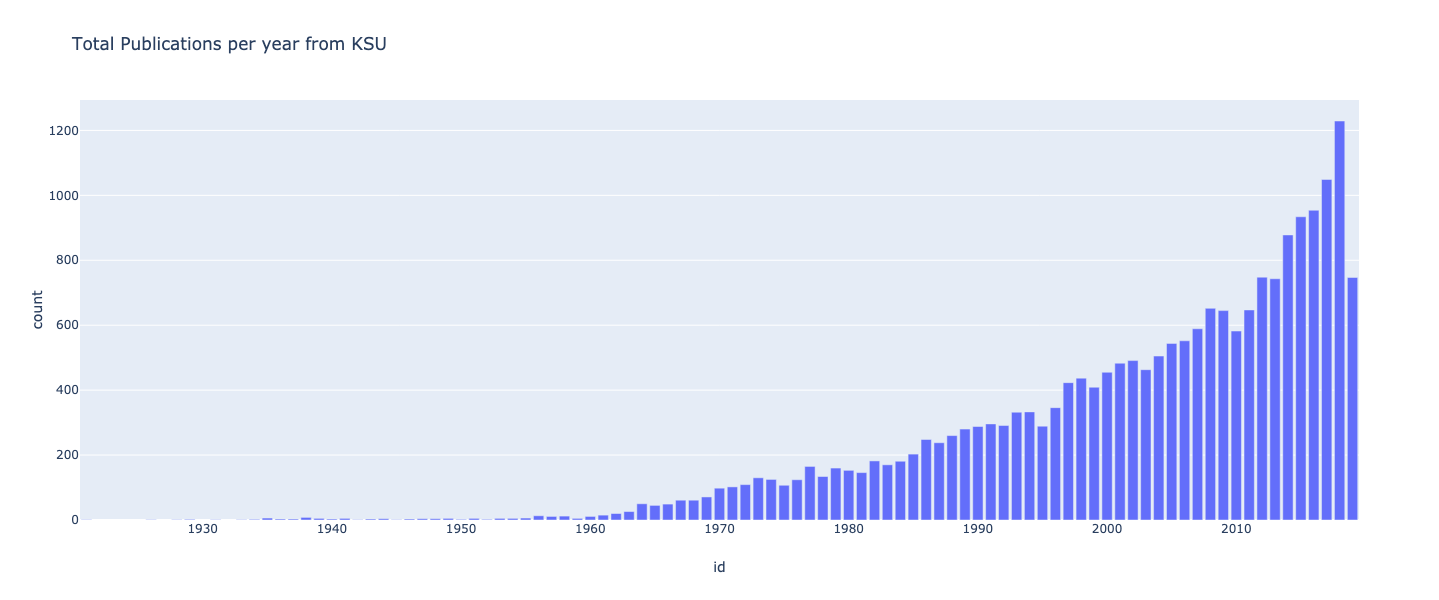

In [14]:
px.bar(df_all_pubs_per_year, x="id", y="count", title="Total Publications per year from KSU")

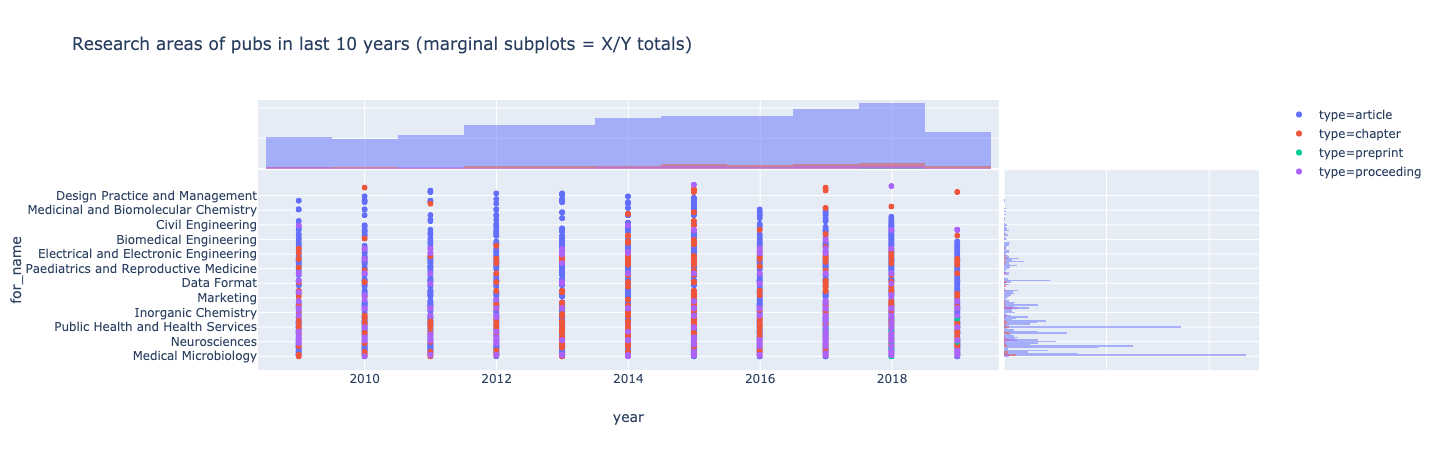

In [16]:
px.scatter(df_pubs_for, x="year", y="for_name", color="type", hover_name="for_name", marginal_x="histogram", marginal_y="histogram", height=800, title="Research areas of pubs in last 10 years (marginal subplots = X/Y totals)")

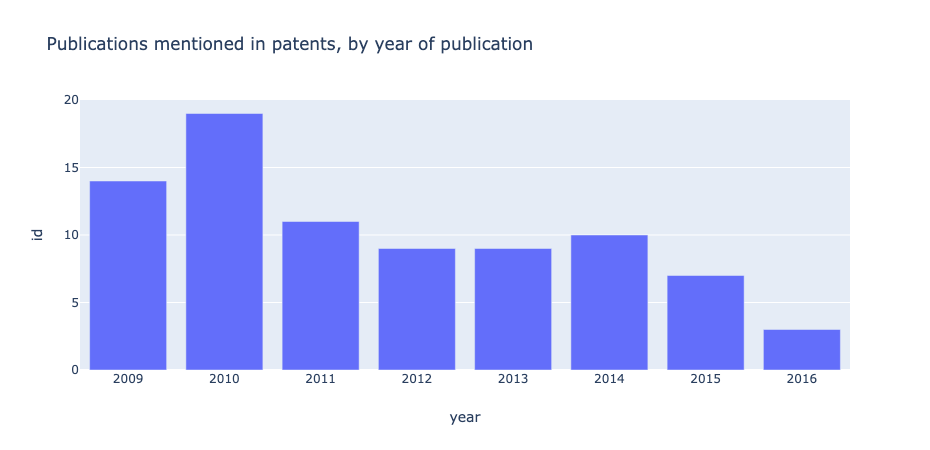

In [17]:
px.bar(df_linked_pubs.groupby('year',  as_index=False).count(), x="year", y="id", title="Publications mentioned in patents, by year of publication")

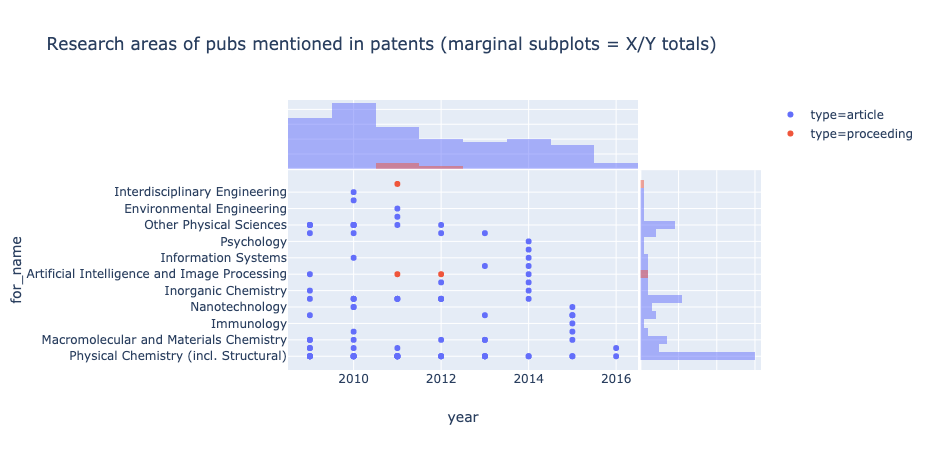

In [18]:
px.scatter(df_linked_pubs_for, x="year", y="for_name", color="type", hover_name="for_name", marginal_x="histogram", marginal_y="histogram", height=800, title="Research areas of pubs mentioned in patents (marginal subplots = X/Y totals)")

## 2.2 Patents information

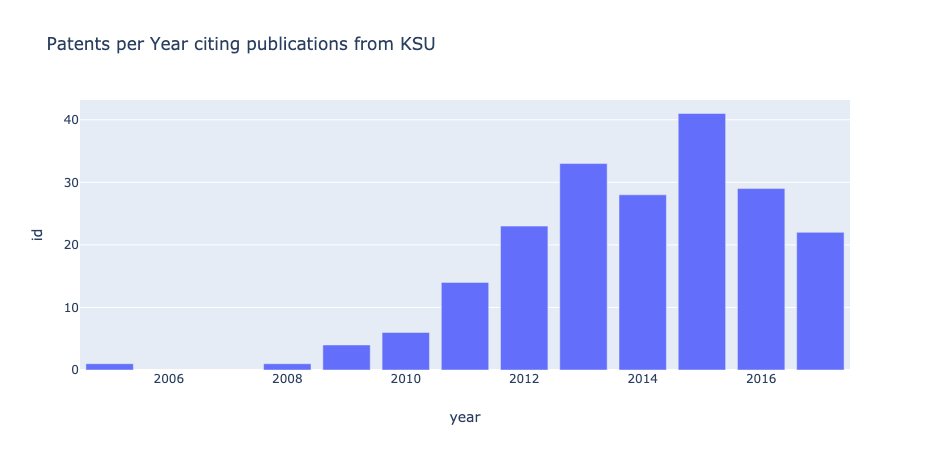

In [19]:
px.bar(df_patent_details.groupby('year',  as_index=False).count(),  x="year", y="id",  title="Patents per Year citing publications from KSU")

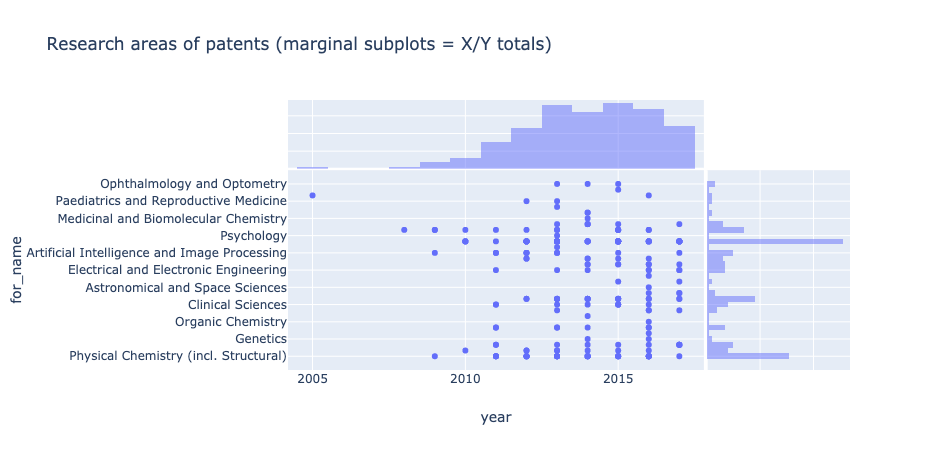

In [20]:
px.scatter(df_patents_for, x="year", y="for_name", hover_name="for_name", marginal_x="histogram", marginal_y="histogram", height=800, title="Research areas of patents (marginal subplots = X/Y totals)")

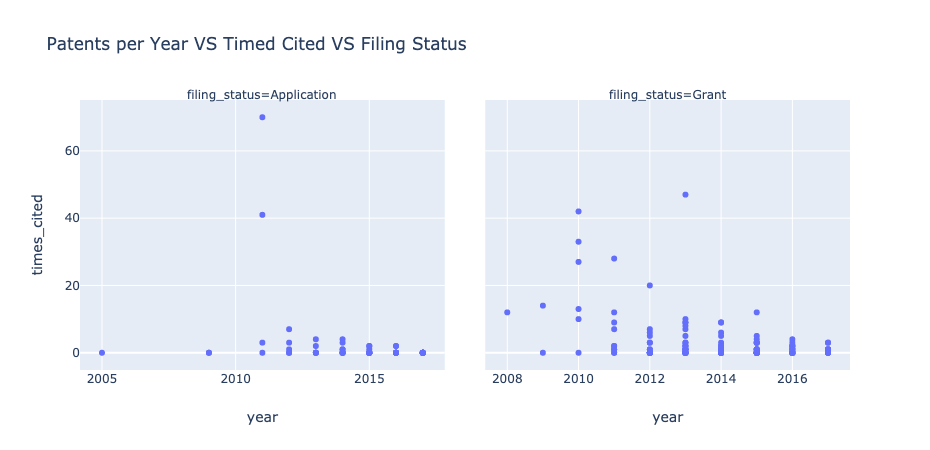

In [21]:
px.scatter(df_patent_details, x="year", y="times_cited", hover_name="title",  hover_data=['id'], facet_col="filing_status", title="Patents per Year VS Timed Cited VS Filing Status")

## 2.3 Assignees of patents

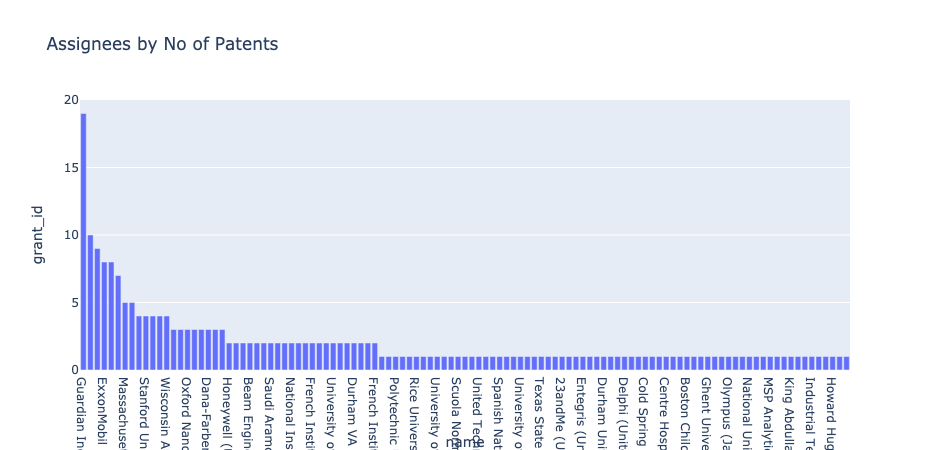

In [22]:
px.bar(df_patents_assignees.groupby('name',  as_index=False).count().sort_values(by="grant_id", ascending=False),  x="name", y="grant_id", hover_name="name",  height=400,  title="Assignees by No of Patents")

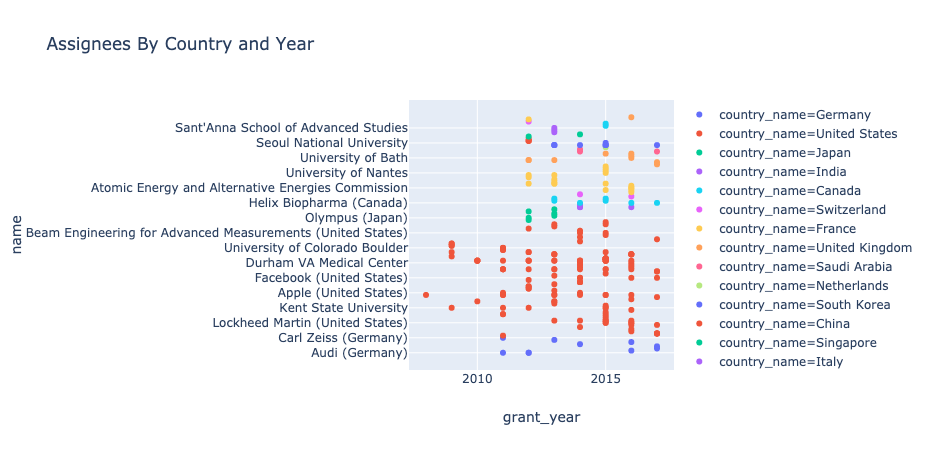

In [23]:
px.scatter(df_patents_assignees,  x="grant_year", y="name", color="country_name", hover_name="name",  hover_data=["id"],  height=800, title="Assignees By Country and Year")

---
# Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 